In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import pandas as pd
from sklearn import preprocessing

from sklearn import linear_model
from sklearn.feature_selection import RFECV

from scipy.stats import pearsonr, expon, kendalltau
from scipy.optimize import curve_fit

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
def standard_scaler(data):
    scaler  = preprocessing.StandardScaler()
    return pd.DataFrame(data = scaler.fit_transform(data), index = data.index.values, columns = data.columns.values)

In [3]:
from sklearn.model_selection import train_test_split

def CalculateR2(Ye, Yp):
    #SS_res = np.sum(np.power(Ye - Yp, 2.0))
    #SS_tot = np.sum(np.power(Ye - np.mean(Ye), 2.0))
    #return 1.0 - SS_res / SS_tot
    
    n = len(Ye)
    r = (n * np.sum(Ye * Yp) - np.sum(Ye) * np.sum(Yp)) / np.sqrt((n * np.sum(Ye * Ye) - np.sum(Ye)**2.0) * (n * np.sum(Yp * Yp) - np.sum(Yp)**2.0))
    return r * r
    

def R2_Leave_One_Out(X1, Y1):
    size = X1.shape[0]
    prediction = np.zeros((size))
    for index in range(size):
        mask = np.zeros((size), dtype = bool)
        mask[index] = True;
        linear = linear_model.LinearRegression()
        linear.fit(X1[~mask].reshape(-1, 1), Y1[~mask].reshape(-1, 1))
        prediction[index] = linear.predict(X1[mask][0].reshape(-1, 1))
    return CalculateR2(Y1.flatten(), prediction)


def R2_Leave_Many_Out(X2, Y2, test_size = 0.25):
    y2          = np.array(())
    prediction = np.array(())
    for i in range(4):
        X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size = test_size)
        linear = linear_model.LinearRegression()
        linear.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))
        y2 = np.append(y2, Y_test)
        prediction = np.append(prediction, linear.predict(X_test.reshape(-1, 1)))
    return CalculateR2(y2, prediction)


def R2_Y_Randomize(X3, Y3):
    Y4 = np.copy(Y3)
    np.random.shuffle(Y4)
    return CalculateR2(X3, Y4)


def getR2Row(x, y, label):
    r2 = CalculateR2(x, y)
    r2_loo = R2_Leave_One_Out(x, y)
    r2_lmo = R2_Leave_Many_Out(x, y)
    r2_y_rand = R2_Y_Randomize(x, y)
    print(f"{label} & {r2:.2} & {r2_loo:.2} & {r2_lmo:.2} & {r2_y_rand:.2} \\\\")

In [4]:
def adjusted_r2(X, Y):
    model = linear_model.LinearRegression()
    model.fit(X, Y) 
    return 1.0 - (1.0 - model.score(X, Y)) * (len(Y) - 1.0) / (len(Y) - X.shape[1] - 1.0)
    
    
# Create a boolean mask N elements long where all
# elements are false except at index n
def create_mask(N, n):
    mask = np.zeros(N, dtype = bool)
    mask[n] = True
    return mask
    

# Return a list of column names that give an optimal 
# adjusted correlation coefficent
def optimal_predictors(X, Y, minOptimizationStepSize = 0.01):
        
    bestCorrelation = 0.0
    N               = X.shape[1]
    optimalMask     = np.zeros((N), dtype = bool)
    
    while True:
        
        masks = [ mask for mask in [ create_mask(N, n) for n in np.arange(N) ] ]
        res   = [ adjusted_r2(X[X.columns[np.bitwise_or(optimalMask, mask)]], Y) for mask in masks ]
    
        bestIndex   = np.argmax(res)
        correlation = res[bestIndex]
    
        #print(bestIndex, correlation)
    
        if (correlation <= bestCorrelation + minOptimizationStepSize):
            break
    
        bestCorrelation = correlation
        optimalMask     = np.bitwise_or(optimalMask, masks[bestIndex])
    
    return X.columns[optimalMask]

In [39]:
# Read in and scale the walkey abundance data

walkeyProteinData = pd.read_excel('nn406018q_si_001.xlsx', sheet_name = 'LCMSMS', index_col = 0)
walkeyProteinData = standard_scaler(walkeyProteinData)

In [40]:
# Read in, scale and drop correlated the 3D predictor data
predictors = pd.read_csv('3DPredictors.csv', index_col = 0)
predictors = standard_scaler(predictors)

corr_matrix = predictors.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
predictors = predictors.drop(predictors[to_drop], axis=1)

In [41]:
#[ np.argmax(predictors.isna()[column].values) for column in predictors.columns.values]

In [42]:
# Get a list of common proteins in both sets
# Remove all proteins not in common set in walkey data
# Remove all proteins not in common set in predictor data

proteinNames = set(walkeyProteinData.index.values) & set(predictors.index.values)
walkeyProteinData = walkeyProteinData[walkeyProteinData.index.isin(proteinNames)]
predictors = predictors[predictors.index.isin(proteinNames)]

In [43]:
# Matrix multiply the descriptors value by the abundance data

raData = pd.DataFrame(np.matmul(walkeyProteinData.values.T, predictors.values), index = walkeyProteinData.columns.values, columns = predictors.columns.values)
#raData = standard_scaler(raData)

In [44]:
# Read in walkey association data and strip out neutral or silver particles

data = pd.read_excel('nn406018q_si_001.xlsx', sheet_name = 'Association', index_col = 0)
data = data[data['Core composition'].isin(['Gold (Au)'])]
data = data[data['Classification'].isin(['Anionic', 'Cationic'])]
walkeyAssociationData = pd.DataFrame(data = data['Log2 transformed Mean'], index = data.index.values)

#walkeyAssociationData = standard_scaler(walkeyAssociationData)

In [45]:
# Get a list of common nanoparticles in both sets
# Remove all nanoparticles not in common set in walkey data
# Remove all nanoparticles not in common set in predictor data

nanoparticles = set(walkeyAssociationData.index.values) & set(raData.index.values)
raData = raData[raData.index.isin(nanoparticles)]
walkeyAssociationData = walkeyAssociationData[walkeyAssociationData.index.isin(nanoparticles)]

Number of predictors: 6
Predictors:  Surface ARG, Surface GLN %, Surface MET %, Surface TYR %, Surface Small %, Surface Basic %
PearsonR: 0.8835809449035363
p-value: 9.492156481668761e-29
R Squared: 0.7807152861966291
R Squared loo: 0.7683908206082182
R Squared lmo: 0.8107367239030993
R Squared yr: 0.008411884763026291
Line1 equation: y = 0.06841230471016753 x  -7.489632375049616
Line2 equation: y = 0.9573733925281189 x  0.0


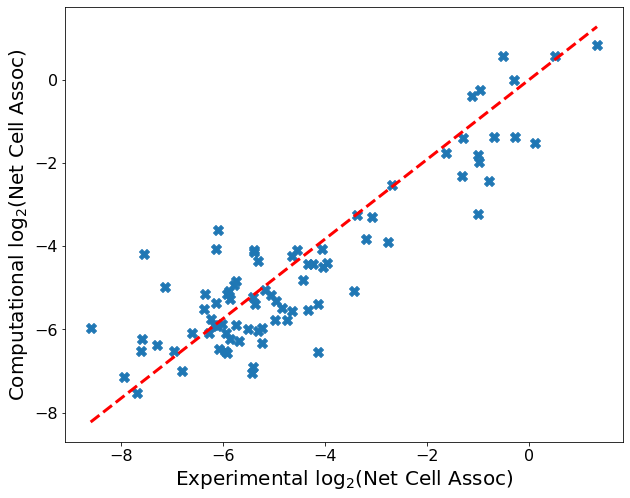

In [83]:
fontsize = 20
titlesize = 20
ticksize = 16


plt.figure(figsize = (10, 8))
plt.tick_params(axis = 'both', which='major', labelsize = ticksize)

linear = linear_model.LinearRegression(fit_intercept = True)

names = optimal_predictors(raData, walkeyAssociationData)

print(f"Number of predictors: {len(names)}")
print(f"Predictors: {','.join(names.values)}")

Y = walkeyAssociationData.values.reshape(-1, 1)
X = raData[names]

linear.fit(X, Y)
Yp = linear.predict(X)

plt.scatter (Y, Yp, s = 100, marker = 'X')
plt.xlabel ("Experimental log$_2$(Net Cell Assoc)", fontsize = fontsize)
plt.ylabel ("Computational log$_2$(Net Cell Assoc)", fontsize = fontsize)
#plt.title ("Charged Gold NP Association Model (3D Predictors Only)")

linear2 = linear_model.LinearRegression(fit_intercept = False)
linear2.fit(Y, Yp)

lineX = np.linspace(np.min(Y), np.max(Y), 1000).reshape(-1, 1)
lineY = linear2.predict(lineX)

plt.plot(lineX, lineY, 'r--', linewidth = 3)

r, p = pearsonr(Y.flatten(), Yp.flatten())

print(f"PearsonR: {r}")
print(f"p-value: {p}")
print(f"R Squared: {CalculateR2(Y, Yp)}")
print(f"R Squared loo: {R2_Leave_One_Out(Y, Yp)}")
print(f"R Squared lmo: {R2_Leave_Many_Out(Y, Yp)}")
print(f"R Squared yr: {R2_Y_Randomize(Y, Yp)}")
print (f"Line1 equation: y = {linear.coef_[0][0]} x  {linear.intercept_[0]}")
print (f"Line2 equation: y = {linear2.coef_[0][0]} x  {linear2.intercept_}")

<h1>Neutrophil</h1>

In [5]:
neutrophil = pd.read_excel('NRCWE Instillation data for David.xlsx', sheet_no = 0, skip_rows = 3)

In [6]:
before  = neutrophil[neutrophil['NM ID CODE'].isin(['NRCWE-025'])]['# Total'].values
after   = neutrophil[neutrophil['NM ID CODE'].isin(['NRCWE-025'])]['Neutro'].values
dose    = neutrophil[neutrophil['NM ID CODE'].isin(['NRCWE-025'])]['Dose (µg/animal)'].values
percent = neutrophil[neutrophil['NM ID CODE'].isin(['NRCWE-025'])]['PMN%'] .values

In [49]:
def Fit(X, m, n ):
    return m * (X)**n

In [50]:
after = np.asarray(after, dtype = float)
before = np.asarray(before, dtype = float)

In [62]:
X= np.array(before * dose, dtype = float)

popt, pcov = curve_fit(Fit, X, after)

print(popt)

#plt.plot(before, (after) ** 0.5, 'ro')

[9.08261117e-07 1.45199381e+00]


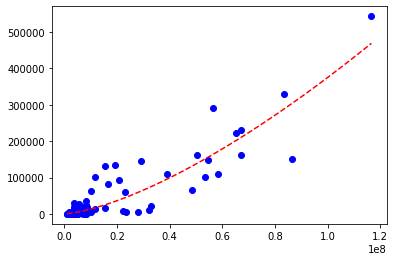

In [63]:
plt.plot(X, after, 'bo')

x = np.linspace(np.min(X), np.max(X))
plt.plot(x, Fit(x, popt[0], popt[1]), '--r')

14.771032821170573 -4.4849173038309


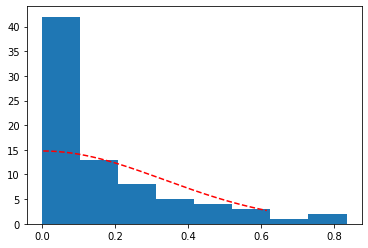

In [13]:
#n, bins, patches = plt.hist(x= (before - after) / dose, bins='auto')
#plt.grid(axis='y', alpha=0.75)
percent
n, bins, patches = plt.hist(x = percent, bins='auto')

x = (bins[1:] - 0.05).reshape(-1, 1)**2
y = np.log(n).reshape(-1, 1)

fit = linear_model.LinearRegression()
fit.fit(x, y)

A = np.exp(fit.intercept_[0])
a = fit.coef_[0][0]

print(A, a)


lx = np.linspace(np.min(x), np.max(x), 500)
ly = A * np.exp(a * lx ** 2)

plt.plot(lx, ly, 'r--')



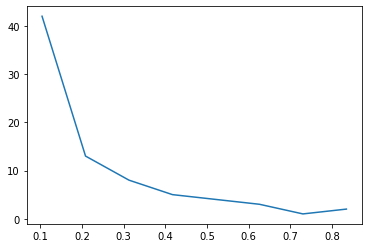

In [141]:
def reorder(names, values):
    return pd.DataFrame(zip(names, values), columns = ['Names', 'Values']).sort_values(by = "Values")['Names'].values

In [142]:
def kendallTauDist(dataSet1,dataSet2):
    '''Calculate the Kendall tau distance between two data sets calculated by performing a bubble-sort and counting the number of swaps. This returns the un-normalised value'''
    error = 0
    if len(dataSet1) != len(dataSet2):
        print("Input data sets are of different length ", len(dataSet1), " v ", len(dataSet2))
        error = 1
    if len(dataSet1) != len(  set(dataSet1) ):
        print("Data set 1 contains duplicated strings")
        error = 1
    if len(dataSet2) != len(  set(dataSet2) ):
        print("Data set 2 contains duplicated strings")
        error = 1
    xorSet = (set(dataSet1)^set(dataSet2)  )
    if len(xorSet ) >0:
        print("Data set 1 and 2 contain different entities: ",)
        print(xorSet)
        error = 1
    if error == 1:
        return - 1 #if an error has been found return -1 before doing anything slow
    dataDict1 = dict(zip (dataSet1, range(len(dataSet1))))
    dataSet2N = []
    for protein in dataSet2:
        dataSet2N.append(dataDict1[protein])
    numSwaps = 0
    for n in range(len(dataSet2N) ):
        for i in range(n+1,len(dataSet2N)):
            if dataSet2N[i] < dataSet2N[n]:
                dataSet2N[n],dataSet2N[i] = dataSet2N[i],dataSet2N[n]
                numSwaps +=1
    return numSwaps

def callktd(names, first, second):
    pdbRanking = reorder(names, first)
    itasserRanking = reorder(names, second)

    numProteins = len(pdbRanking)
    ktDist =  kendallTauDist(pdbRanking,itasserRanking)
    if ktDist!=-1:
        return 1 - 2*(ktDist *2.0/( numProteins*(numProteins-1.0)))

In [143]:
print(f"{callktd(names, goldx5, goldy5):0.2f} & {callktd(names, goldx50, goldy50):0.2f} & {callktd(names, goldx100, goldy100):0.2f} & {callktd(names, goldx200, goldy200):0.2f} \\\\")
print(f"{callktd(names, tio2x5, tio2y5):0.2f} & {callktd(names, tio2x50, tio2y50):0.2f} & {callktd(names, tio2x100, tio2y100):0.2f} & {callktd(names, tio2x200, tio2y200):0.2f} \\\\")
print(f"{callktd(names, sio2x5, sio2y5):0.2f} & {callktd(names, sio2x50, sio2y50):0.2f} & {callktd(names, sio2x100, sio2y100):0.2f} & {callktd(names, sio2x200, sio2y200):0.2f} \\\\")
print(f"{callktd(names, cdsex5, cdsey5):0.2f} & {callktd(names, cdsex50, cdsey50):0.2f} & {callktd(names, cdsex100, cdsey100):0.2f} & {callktd(names, cdsex200, cdsey200):0.2f} \\\\")

0.56 & 0.63 & 0.61 & 0.64 \\
0.68 & 0.65 & 0.66 & 0.66 \\
0.50 & 0.40 & 0.39 & 0.39 \\
0.88 & 0.88 & 0.88 & 0.88 \\


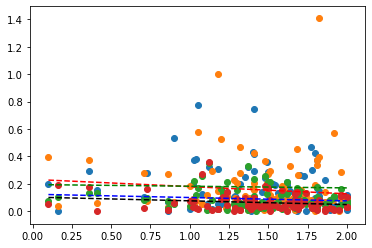

In [148]:
def trend_plot(X, A, B, c):
    Y = np.abs((A-B)/A)
    plt.scatter(X, Y)
    linear = LinearRegression(fit_intercept = True)
    linear.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    trendx = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    trendy = linear.predict(trendx)
    plt.plot(trendx, trendy, f"{c}--")

    
trend_plot(cscore[mask], sio2x50, sio2y50, 'r')
trend_plot(cscore[mask], tio2x50, tio2y50, 'g')
trend_plot(cscore[mask], goldx50, goldy50, 'b')
trend_plot(cscore[mask], cdsex50, cdsey50, 'k')
